In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import metrics

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
df=pd.read_csv('Claim.csv')
df

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                   328   48         521585       17-10-2014           OH   
1                   228   42         342868       27-06-2006           IN   
2                   134   29         687698       06-09-2000           OH   
3                   256   41         227811       25-05-1990           IL   
4                   228   44         367455       06-06-2014           IL   
..                  ...  ...            ...              ...          ...   
995                   3   38         941851       16-07-1991           OH   
996                 285   41         186934       05-01-2014           IL   
997                 130   34         918516       17-02-2003           OH   
998                 458   62         533940       18-11-2011           IL   
999                 456   60         556080       11-11-1996           OH   

    policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0      250/500               1000                1406.91               0   
1      250/500               2000                1197.22         5000000   
2      100/300               2000                1413.14         5000000   
3      250/500               2000                1415.74         6000000   
4     500/1000               1000                1583.91         6000000   
..         ...                ...                    ...             ...   
995   500/1000               1000                1310.80               0   
996    100/300               1000                1436.79               0   
997    250/500                500                1383.49         3000000   
998   500/1000               2000                1356.92         5000000   
999    250/500               1000                 766.19               0   

     insured_zip  ... police_report_available total_claim_amount injury_claim  \
0         466132  ...                     YES              71610         6510   
1         468176  ...                       ?               5070          780   
2         430632  ...                      NO              34650         7700   
3         608117  ...                      NO              63400         6340   
4         610706  ...                      NO               6500         1300   
..           ...  ...                     ...                ...          ...   
995       431289  ...                       ?              87200        17440   
996       608177  ...                       ?             108480        18080   
997       442797  ...                     YES              67500         7500   
998       441714  ...                     YES              46980         5220   
999       612260  ...                       ?               5060          460   

    property_claim vehicle_claim   auto_make  auto_model auto_year  \
0            13020         52080        Saab         92x      2004   
1              780          3510    Mercedes        E400      2007   
2             3850         23100       Dodge         RAM      2007   
3             6340         50720   Chevrolet       Tahoe      2014   
4              650          4550      Accura         RSX      2009   
..             ...           ...         ...         ...       ...   
995           8720         61040       Honda      Accord      2006   
996          18080         72320  Volkswagen      Passat      2015   
997           7500         52500      Suburu     Impreza      1996   
998           5220         36540        Audi          A5      1998   
999            920          3680    Mercedes        E400      2007   

    fraud_reported _c39  
0                Y  NaN  
1                Y  NaN  
2                N  NaN  
3                Y  NaN  
4                N  NaN  
..             ...  ...  
995              N  NaN  
996              N  NaN  
997              N  NaN  
998              N  NaN  
999              N  NaN  

[1000 rows x 40 columns]

In [4]:
df.shape

(1000, 40)

In [5]:
df.dtypes

months_as_customer               int64
age                              int64
policy_number                    int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_zip                      int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_location               object
incident_hour_of_the_day 

As we can see there is no use of Policy no so droping it and also changing dating from string

In [6]:
df.drop('policy_number',axis=1,inplace=True)
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['insured_zip'] = df['insured_zip'].apply(str)
df['bodily_injuries'] = df['bodily_injuries'].apply(str)
df['incident_date'] = pd.to_datetime(df['incident_date'])

In [7]:
for column_data in df.dtypes.items():
    column, dtype = column_data
    if dtype == 'object':
        print(column)
        print(df[column].value_counts())
        print('-'*30)

policy_state
OH    352
IL    338
IN    310
Name: policy_state, dtype: int64
------------------------------
policy_csl
250/500     351
100/300     349
500/1000    300
Name: policy_csl, dtype: int64
------------------------------
insured_zip
469429    2
446895    2
456602    2
431202    2
477695    2
         ..
472253    1
476315    1
452647    1
620493    1
615921    1
Name: insured_zip, Length: 995, dtype: int64
------------------------------
insured_sex
FEMALE    537
MALE      463
Name: insured_sex, dtype: int64
------------------------------
insured_education_level
JD             161
High School    160
Associate      145
MD             144
Masters        143
PhD            125
College        122
Name: insured_education_level, dtype: int64
------------------------------
insured_occupation
machine-op-inspct    93
prof-specialty       85
tech-support         78
sales                76
exec-managerial      76
craft-repair         74
transport-moving     72
priv-house-serv      71
other-

In [8]:
# Location don't mater much as we have the ZIP code so droping it 
df.drop(['incident_location'],axis=1,inplace=True)

In [9]:
df.columns

Index(['months_as_customer', 'age', 'policy_bind_date', 'policy_state',
       'policy_csl', 'policy_deductable', 'policy_annual_premium',
       'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim', 'auto_make', 'auto_model',
       'auto_year', 'fraud_reported', '_c39'],
      dtype='object')

In [10]:
df.shape

(1000, 38)

In [11]:
df.isnull().sum()

months_as_customer                0
age                               0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage                   0
bodily_injuries                   0
witnesses                   

We can see there is all null in _c39 so droping it

In [12]:
df.drop('_c39',axis=1,inplace=True)

# EDA

<AxesSubplot:>

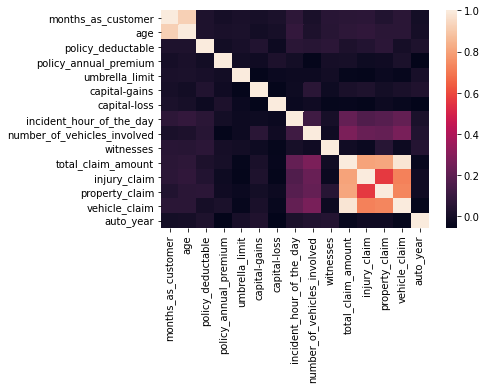

In [13]:
sns.heatmap(df.corr())

In [14]:
df.describe

<bound method NDFrame.describe of      months_as_customer  age policy_bind_date policy_state policy_csl  \
0                   328   48       2014-10-17           OH    250/500   
1                   228   42       2006-06-27           IN    250/500   
2                   134   29       2000-06-09           OH    100/300   
3                   256   41       1990-05-25           IL    250/500   
4                   228   44       2014-06-06           IL   500/1000   
..                  ...  ...              ...          ...        ...   
995                   3   38       1991-07-16           OH   500/1000   
996                 285   41       2014-05-01           IL    100/300   
997                 130   34       2003-02-17           OH    250/500   
998                 458   62       2011-11-18           IL   500/1000   
999                 456   60       1996-11-11           OH    250/500   

     policy_deductable  policy_annual_premium  umbrella_limit insured_zip  \
0           

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          1000 non-null   int64         
 2   policy_bind_date             1000 non-null   datetime64[ns]
 3   policy_state                 1000 non-null   object        
 4   policy_csl                   1000 non-null   object        
 5   policy_deductable            1000 non-null   int64         
 6   policy_annual_premium        1000 non-null   float64       
 7   umbrella_limit               1000 non-null   int64         
 8   insured_zip                  1000 non-null   object        
 9   insured_sex                  1000 non-null   object        
 10  insured_education_level      1000 non-null   object        
 11  insured_occupation           1000 non-null  

# Univariate Analysis

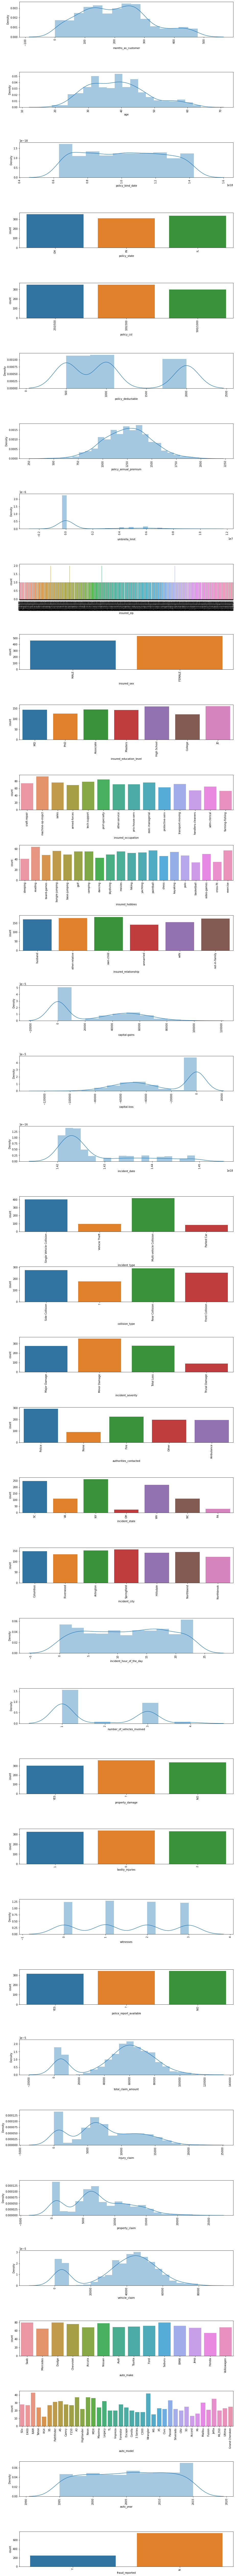

In [16]:
plt.figure(figsize=[15,200])
for i, column_data in enumerate(df.dtypes.items()):
    column,dtype = column_data
    plt.subplot(40,1,i+1)
    plt.subplots_adjust(hspace=1)
    
    if dtype == 'object':
        plt.xticks(rotation=90)
        sns.countplot(df[column])
    else:
        plt.xticks(rotation=90)
        sns.distplot(df[column],kde=True)

We can say that
Very Less Fraud case are there
Female are more insured than male
Most of the colission are single or multiple

# Bivariate Analysis

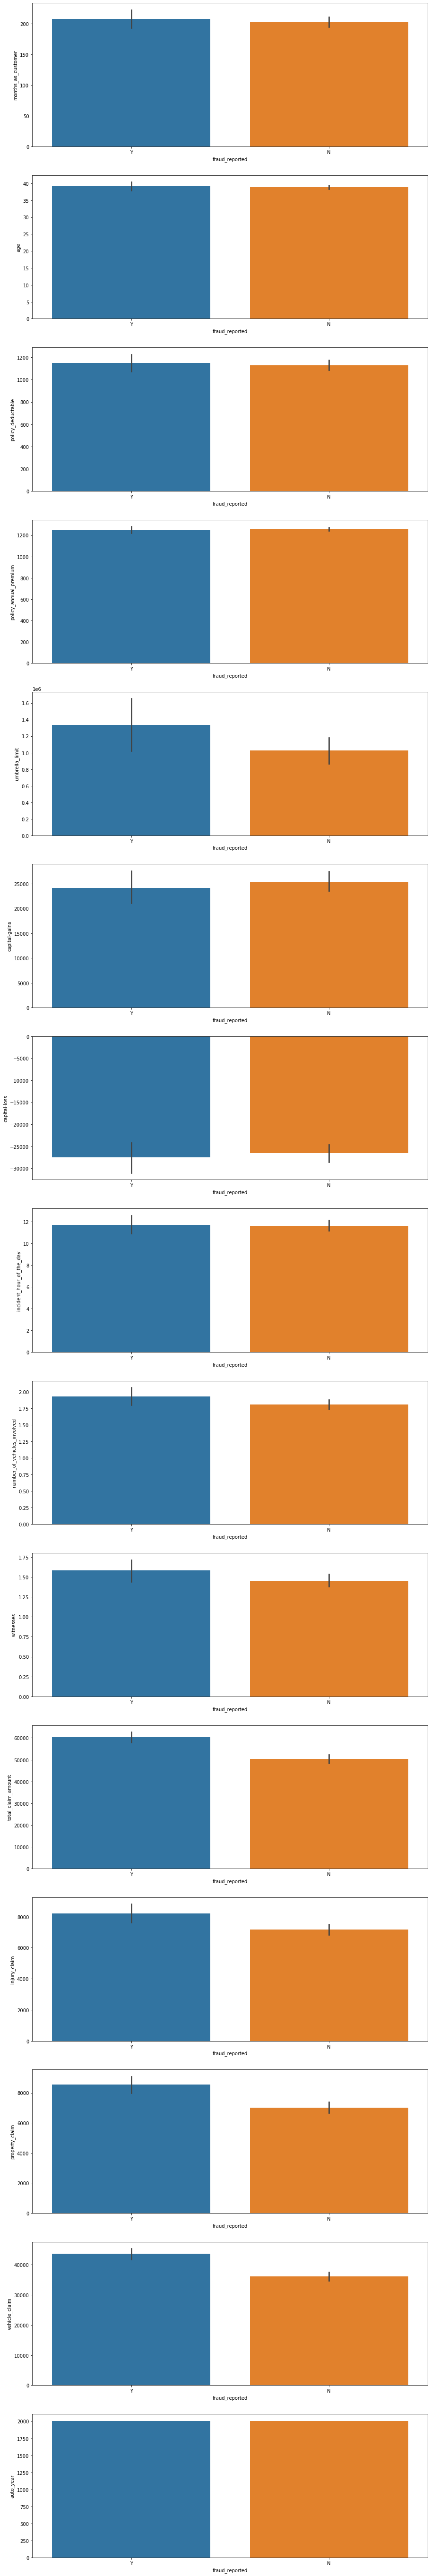

In [17]:

plt.figure(figsize=[15,200])
j = 0 
for column, dtype in df.drop(['fraud_reported','policy_bind_date','incident_date'],axis=1).dtypes.items():
    if dtype != 'object':
        plt.subplot(30,1,j+1)   
        sns.barplot(df['fraud_reported'],df[column],)
        j += 1

We can see that


More Unmera limit more fraud reported
High claim vechinal report more fraud
High Property Claim reported more fraud
When high claim amount then more chance of fraud

# Checking for outliers

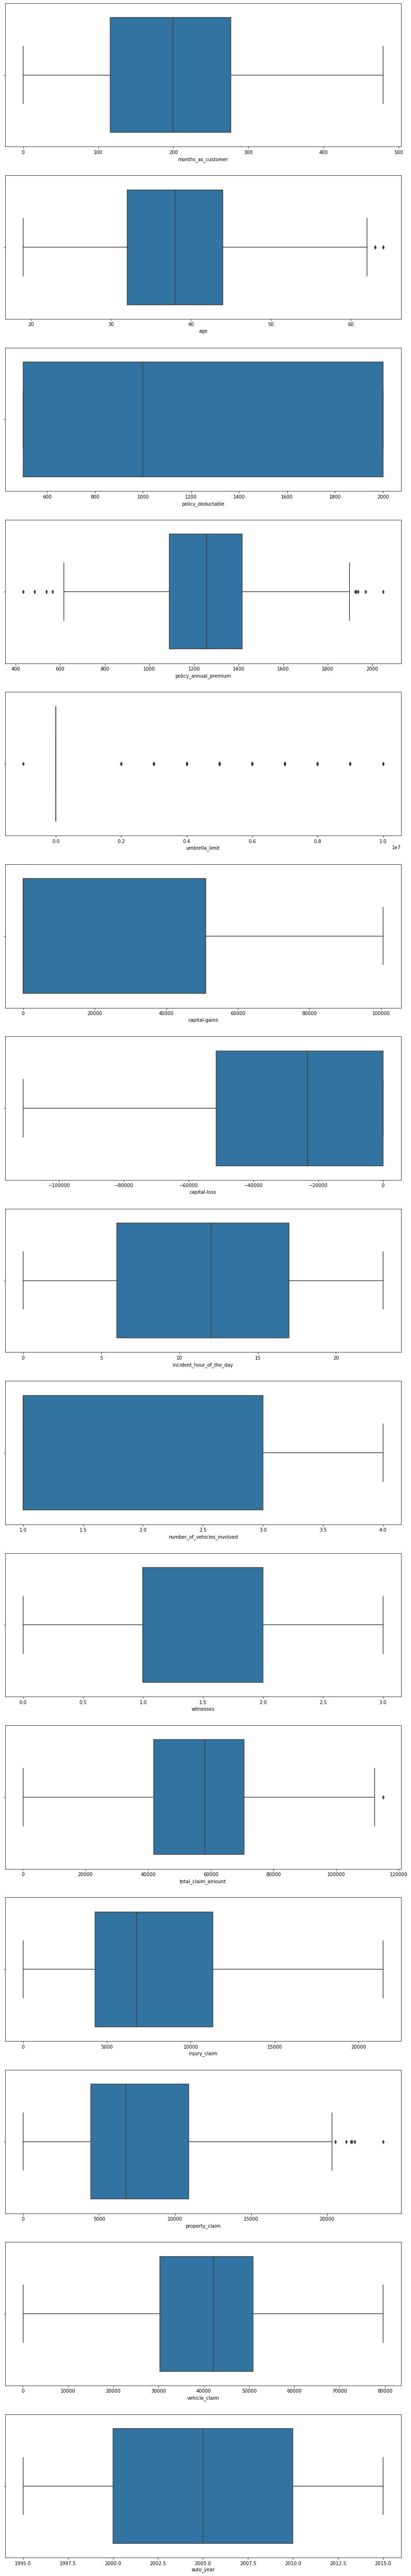

In [18]:
plt.figure(figsize=[15,200])
df_conti = df.drop(['fraud_reported','policy_bind_date','incident_date'],axis=1)
j = 0 
for column, dtype in df_conti.dtypes.items():
    if dtype != 'object':
        plt.subplot(30,1,j+1)    
        sns.boxplot(df[column],)
        j += 1

WE can see there is a outliers present lets see how many

In [19]:
conti_column = [column[0] for column in df.dtypes.items() if column[1] != 'object' and column[1] != '<M8[ns]']
df[np.abs(stats.zscore(df[conti_column]))>3]

months_as_customer  age policy_bind_date policy_state policy_csl  \
31                  166   37       2008-06-19           IL    100/300   
48                  175   34       2008-07-01           IN   500/1000   
88                   31   36       1999-08-15           IL   500/1000   
115                 258   46       1999-09-03           IN    100/300   
119                 245   39       2001-04-21           OH    250/500   
229                 154   37       2010-01-28           IL    250/500   
248                 101   27       2007-10-02           IL    250/500   
262                 232   43       2001-05-16           OH    250/500   
314                  91   30       2010-06-18           IL    250/500   
430                 264   47       2005-07-03           IN    250/500   
458                 347   51       1996-10-18           OH   500/1000   
500                   1   29       2006-05-24           OH   500/1000   
503                 289   48       1995-08-29           IL   500/1000   
657                 252   39       2004-02-28           IL   500/1000   
700                  85   31       2004-10-03           IL    250/500   
763                  66   30       2003-06-24           IN   500/1000   
807                 186   38       2008-07-28           IN    250/500   
875                 195   37       1991-11-07           IL    100/300   
922                  55   35       2011-04-02           IL   500/1000   
975                 240   40       2004-11-09           IN    100/300   

     policy_deductable  policy_annual_premium  umbrella_limit insured_zip  \
31                2000                1337.28         8000000      610393   
48                1000                1123.87         8000000      446326   
88                2000                1318.24         9000000      601748   
115               1000                1110.37        10000000      455365   
119                500                 964.79         8000000      460675   
229               1000                2047.59               0      439269   
248               1000                 433.33               0      603269   
262                500                1483.91         8000000      431531   
314               2000                1316.63         8000000      613178   
430               2000                1181.46        10000000      601117   
458                500                1480.79         9000000      432399   
500                500                 854.58               0      612826   
503                500                1173.37         8000000      461744   
657                500                1312.22         9000000      609949   
700               2000                1234.69         9000000      613471   
763                500                 484.67               0      608309   
807               2000                1347.31               0      436467   
875               1000                1406.52         8000000      619148   
922                500                1198.44         8000000      438923   
975                500                1533.71         9000000      469856   

    insured_sex  ... witnesses police_report_available total_claim_amount  \
31         MALE  ...         2                       ?              67140   
48       FEMALE  ...         0                     YES               7290   
88       FEMALE  ...         1                     YES               4700   
115        MALE  ...         1                       ?              47700   
119      FEMALE  ...         1                       ?              72820   
229      FEMALE  ...         3                      NO              79530   
248        MALE  ...         3                      NO               5900   
262        MALE  ...         1                       ?              70600   
314      FEMALE  ...         0                       ?              84500   
430      FEMALE  ...         2                     YES              62370   
458   


We can see very less no of outliers there so leaving it

# Label Encoding

In [20]:
df = df.apply(LabelEncoder().fit_transform)

# Splitting the data

In [21]:
X = df.drop('fraud_reported',axis=1)
y = df['fraud_reported']

# Checking for skewness

In [22]:
df.skew().abs().sort_values()

insured_education_level        0.000148
insured_zip                    0.001683
total_claim_amount             0.003492
policy_annual_premium          0.004022
incident_date                  0.005157
vehicle_claim                  0.014526
bodily_injuries                0.014777
auto_make                      0.018797
witnesses                      0.019636
policy_bind_date               0.023500
policy_state                   0.026177
incident_hour_of_the_day       0.035584
auto_year                      0.048289
incident_city                  0.049531
police_report_available        0.052967
insured_occupation             0.058881
insured_hobbies                0.061563
policy_deductable              0.063505
property_claim                 0.071055
insured_relationship           0.077488
auto_model                     0.080773
policy_csl                     0.088928
months_as_customer             0.092231
incident_type                  0.101507
injury_claim                   0.105325


# Power Transform

In [23]:
X_transformed = PowerTransformer().fit_transform(X)
X = pd.DataFrame(X_transformed,columns=X.columns)

# Building Model

In [24]:
models = {
    'logisticRegression' : LogisticRegression(),
    'decisionTreeClassifier' : DecisionTreeClassifier(),
    'svc' : SVC(probability=True),
    'kNeighborsClassifier' : KNeighborsClassifier()
}

In [25]:
def build_model(model_obj):
    
    name, model = model_obj
        
    print('----------------------------------')
    print('*****',name,'******')
    print('----------------------------------')
    
    multi_class = False
    
    if len(y_train.value_counts()) > 2:
        multi_class = True
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy_score = metrics.accuracy_score(y_test,y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
    
    if not multi_class:
        y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr , _ = metrics.roc_curve(y_test,y_pred_proba)
        auc = metrics.roc_auc_score(y_test,y_pred_proba)
    
        plt.figure(figsize=(5,5))
        plt.plot(fpr,tpr)
        plt.title('AUC ROC Curve for ' + name)
    
        print('auc: ',auc)
        plt.show()
        
        
        
    kFold = KFold(n_splits=3,shuffle=True,random_state=42)
    scores = cross_val_score(model,X,y,cv=kFold,scoring='accuracy',n_jobs=-1)
    
    mean_cv_scores = np.mean(scores)
    std_cv_scores = np.std(scores)
    
    diff_acc_score_cv_score = np.abs(accuracy_score - mean_cv_scores)
    
    print('Confussion matrix: \n',confusion_matrix)
    print('\nscore: ',accuracy_score)
    
    print('Cross Val Score: ',mean_cv_scores)
    print('Cross Val std: ',std_cv_scores)
    print('Diff Between score and CV score: ', diff_acc_score_cv_score)
    print('__________________________________________\n'*2)
    
    return (name, accuracy_score, mean_cv_scores, std_cv_scores, diff_acc_score_cv_score, model)

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,shuffle=True)

----------------------------------
***** logisticRegression ******
----------------------------------
auc:  0.7183753364325912


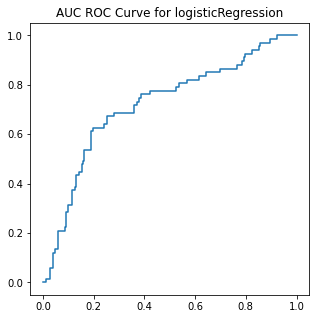

Confussion matrix: 
 [[162  21]
 [ 42  25]]

score:  0.748
Cross Val Score:  0.7660414905923888
Cross Val std:  0.03282022664838996
Diff Between score and CV score:  0.018041490592388798
__________________________________________
__________________________________________

----------------------------------
***** decisionTreeClassifier ******
----------------------------------
auc:  0.6655656145501998


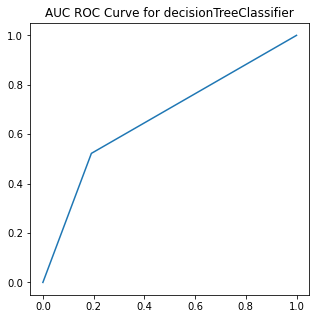

Confussion matrix: 
 [[148  35]
 [ 32  35]]

score:  0.732
Cross Val Score:  0.7880755006503509
Cross Val std:  0.05389139322678953
Diff Between score and CV score:  0.05607550065035094
__________________________________________
__________________________________________

----------------------------------
***** svc ******
----------------------------------
auc:  0.700106027240845


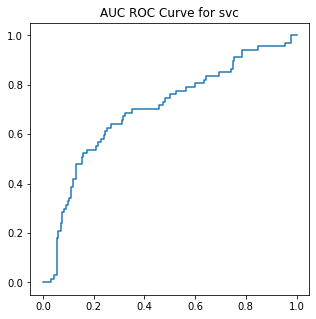

Confussion matrix: 
 [[173  10]
 [ 57  10]]

score:  0.732
Cross Val Score:  0.7480294665923409
Cross Val std:  0.02140532887359731
Diff Between score and CV score:  0.016029466592340946
__________________________________________
__________________________________________

----------------------------------
***** kNeighborsClassifier ******
----------------------------------
auc:  0.6309844221515374


C:\Users\dell\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


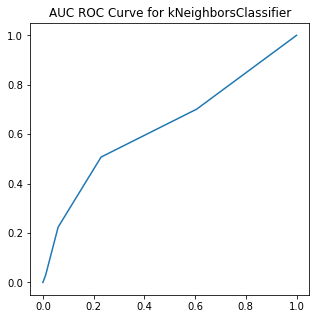

Confussion matrix: 
 [[172  11]
 [ 52  15]]

score:  0.748
Cross Val Score:  0.7460094825364286
Cross Val std:  0.007139416403622366
Diff Between score and CV score:  0.001990517463571373
__________________________________________
__________________________________________



In [27]:
final_model_list = []
for one_model in models.items():
    
    name, accuracy_score, mean_cv_scores, std_cv_scores, diff_acc_score_cv_score, model = build_model(one_model)
    final_model_list.append({
        'name': name,
        'accuracy_score': accuracy_score,
        'mean_cv_scores': mean_cv_scores,
        'std_cv_scores': std_cv_scores,
        'diff_acc_score_cv_score': diff_acc_score_cv_score,
        'model': model,

    })

# Grid search CV with best model

In [28]:
# The Best model is 
sorted(final_model_list,key=lambda item : item['diff_acc_score_cv_score'])[0]['name']

'kNeighborsClassifier'

In [29]:
kNeighborsClassifier = sorted(final_model_list,key=lambda item : item['diff_acc_score_cv_score'])[0]['model']

In [30]:
param_grid = {
    'n_neighbors': [5,6,7],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform','distance'],
    'leaf_size' : [30,40],
    
}
gridSearchCV = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,n_jobs=-1)
gridSearchCV.fit(X_train,y_train)
print(gridSearchCV.best_score_)
print(gridSearchCV.best_params_)

0.7613333333333333
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'uniform'}


# Saving the Model

In [31]:
pickle.dump(kNeighborsClassifier,open('kNeighborsClassifier_primary_fuel.pkl','wb'))